<a href="https://colab.research.google.com/github/rohan2810/NYU-AI-Winter-School/blob/master/Lab_2_(experienced)_Classification_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

**NOTE**: Please make a personal copy of this notebook by selecting 'File' > 'Save a copy in Drive' in the menu bars above.

# Classification

Like regression, classification is a fundamental and general type of machine of machine learning problem. Classification involves assigning an input to a **class**. Like regression problems, classification problems are ubiquitous in the real world:
* CAPTCHAs: inputs are images and classes are whether or not there is a bus/truck/etc.
* Predicting if an email or phone number is spam or not.
* Determining the genre of a movie or book.

More formally, classification problems are described as learning a function $f$ that assigns an input $x$ to one of $K$ classes $c \in C$, where $C$ is the set of all classes. We generally represent the classes as integers (e.g. 0, 1, 2, etc.), where the value and order of the integers doesn't reflect any structure in the classes.

## Setting and Data

For this lab, we'll use consider an artificial task of distinguishing whether a point belongs to one of two classes. The points will be two dimensional (i.e. $\in \mathbb{R}^2$) and for convenience we'll call the classes 0 and 1.

In [ ]:
! pip install ipympl

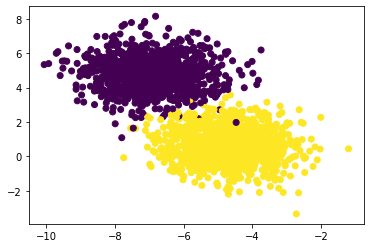

In [ ]:
from sklearn.datasets.samples_generator import make_blobs
# Follow these instructions to set up matplotlib widget for Jupyter Lab
# https://github.com/matplotlib/jupyter-matplotlib#installation
%matplotlib widget
%matplotlib inline

import numpy
import matplotlib.pyplot as plot
from tqdm import tqdm

# random_seed = numpy.random.randint(0,100)
random_seed = 12

X, y = make_blobs(n_samples=2000, centers=2, n_features=2,
                  random_state=random_seed)

plot.figure()
plot.scatter(X[:,0], X[:,1], c=y)
plot.show()

In [ ]:
print(X.shape)

# split into train and test
n_exs = len(X)
n_train = int(n_exs * .8)
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

(2000, 2)


## Model

To model this problem, we'll use a model that estimates the **probability** that a given input belongs to each of the $K$ classes (e.g. estimating $p(y_i = 1|x_i)$).
Because probabilities must be in $[0, 1]$, the model's outputs must be in that range as well.
To do this, we'll use a popular classification model called logistic regression (which, despite the name is a classification model).
This model gets its name from the logistic function $\sigma$, which looks like the following:

$$ \sigma(a) = \frac{1}{1 + e^{-a}} $$

**(exercise)** Let's write a function implementing $\sigma$ and plot it to see what it looks like.

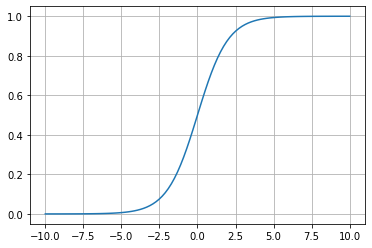

In [ ]:
def logistic(a): # delete
  return 1. / (1. + np.exp(-a))

def plot_function(f): # keep
    x = np.linspace(-10,10,100)
    y = f(x)
    
    return plt.plot(x,y)

plt.figure()
plot_function(logistic)
plt.grid(True)
plt.show()


As we can see, the logistic function has a minimum value of 0 and a maximum value of 1, which is perfect for estimating probabilities.

The logistic function has a nice derivative, which will come in handy later:

$$ \frac{d \sigma}{d a} = \frac{d}{d a} (1 + e^{-a})^-1$$
$$ = - (1 + e^{-a})^{-2} * -e^{-a} $$
$$ = \frac{e^{-a}}{(1+e^{-a})^{-2}} $$
$$ = \frac{e^{-a}}{1+e^{-a}} * \frac{1}{1+e^{-a}} $$
$$ = \sigma(a) * (1 - \sigma(a)) $$

The logistic regression model estimates the probability that the input belongs to the positive class ($p_{+}$) as follows:

$$p_{+} = p(y = 1|x) = \sigma(-w^\top x + b) = \frac{1}{1 + e^{-w^\top x + b}}$$

where $w \in R^{d}, b \in R$. 
Essentially, the model is the logistic function sigma ($\sigma$) applied to a linear transformation of the input $x$ using weight vector $w$.

Then because we only have two classes and probabilities must sum to 1, we also have

$$p_{-} = p(y = 0|x) = 1 - p_{+}$$
$$ = 1 - \frac{1}{1 + e^{-w^\top x + b}}$$
$$ = \frac{e^{-w^\top x + b}}{1 + e^{-w^\top x + b}} $$

Once we have the probabilities for each class, we need to actually convert these probabilities into a prediction of the input's class.
To do so, we'll simply predict that the input belongs to the most probable class.

**(exercise)** Let's implement this model and write a function to obtain predictions given the probability of the positive class:

In [ ]:
def log_reg(x, w, b):
    """This function computes logistic unit $p_{+}$ .
    :param x: input x with n_dim features
    :param w: weght vector
    :param b: bias term
    """
    pre_sigmoid = np.matmul(x, w) + b
    logit = logistic(pre_sigmoid)
    return logit
  
def predict(prob_pos):
    return (prob_pos >= 0.5).astype(int)

## Training

Like with the linear regression model we used for regression, we also need to **optimize** this model by finding the "best" weights $w$. Again, "best" is defined with respect to an objective function, and for logistic regression we'll use the following objective function $L$:

$$ L(x, y, w) = -(y \cdot \log(p_{+}) + (1 - y) \cdot \log(1 - p_{+})) $$
$$ = - (y \cdot \log \big(\frac{1}{1 + e^{-w^\top x + b}}\big) + (1 - y) \cdot \log \big(1 - \frac{1}{1 + e^{-w^\top x + b}}\big))$$

To optimize this function, we want to solve for $w$ when the gradient is equal to zero, so let's start by computing the gradient using the chain rule. Specifically, we'll compute it as $\nabla_w L = \nabla_{p_+} L * \nabla_w p_+$ and similarly for $b$:

$$ \nabla_{p_+} L = -\big( \frac{y}{p_+} - \frac{1-y}{1 - p_+} \big)$$
$$ = - \big( \frac{y(1 - p_+) - (1-y)p_+}{p_+ (1 - p_+)} \big)$$
$$ = -\frac{1}{p_+ (1 - p_+)} (y - p_+) $$


$$ \nabla_w p_+ = \nabla_w \sigma(-wx + b)$$
$$ = -x \sigma(-wx + b) (1 - \sigma(-wx + b)) $$

$$ \nabla_b p_+ = \nabla_w \sigma(-wx + b)$$
$$ = \sigma(- wx + b) (1 - \sigma(-wx + b)) $$

Putting it all together:

$$ \nabla_w L = \nabla_{p_+} L * \nabla_w p_+ $$
$$ = -\frac{1}{p_+ (1 - p_+)} (y - p_+) * -x \sigma(- wx+b) (1 - \sigma(-wx+b)) $$
$$ = -\frac{\sigma(- wx+b)(1 - \sigma(-wx+b))}{\sigma(-wx+b) (1 - \sigma(-wx+b))} (y - \sigma(-wx+b)) * -x $$
$$ = x * (y - \sigma(-wx+b)) $$

$$ \nabla_b L = \nabla_{p_+} L * \nabla_b p_+ $$
$$ = -(y - \sigma(-wx+b)) $$

**(exercise)** Let's implement this objective function and its gradient:

In [ ]:
EPS = 1e-5

def objective_fn(x, y, w, b):
    """This function computes the distance between targets and predicions.
    :param logits: output from logistic unit
    :param labels: target label
    """
    logits = log_reg(x,w,b)
    labels = y
    loss = -(labels * np.log(logits + EPS) + (1 - labels) * np.log(1 - logits + EPS))
    return loss

def grad_objective_fn(x, y, w, b):
    dw = np.matmul((log_reg(x,w,b) - y), x)
    db = (log_reg(x,w,b) - y)
    db = np.sum(db)
    return dw, db

Unlike with linear regression, we can't get a closed form solution (i.e. a formula) for the optimal value of the weights. Instead, we rely on the fact that the gradient (or derivative, in 1-D) points opposite the direction of greatest increase. If we repeatedly take "steps" along the gradient (i.e. update the value of $w$ according to its gradient) and recompute its value after each step, we will eventually and provably reach the optimal value of the weights. This method of optimizing is known as **gradient descent**. Consider the pictorial representations below:

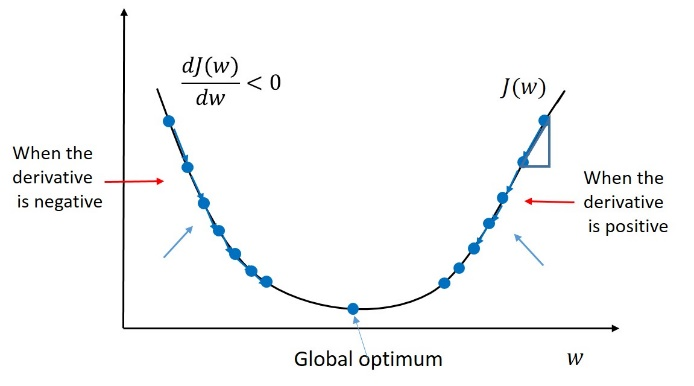


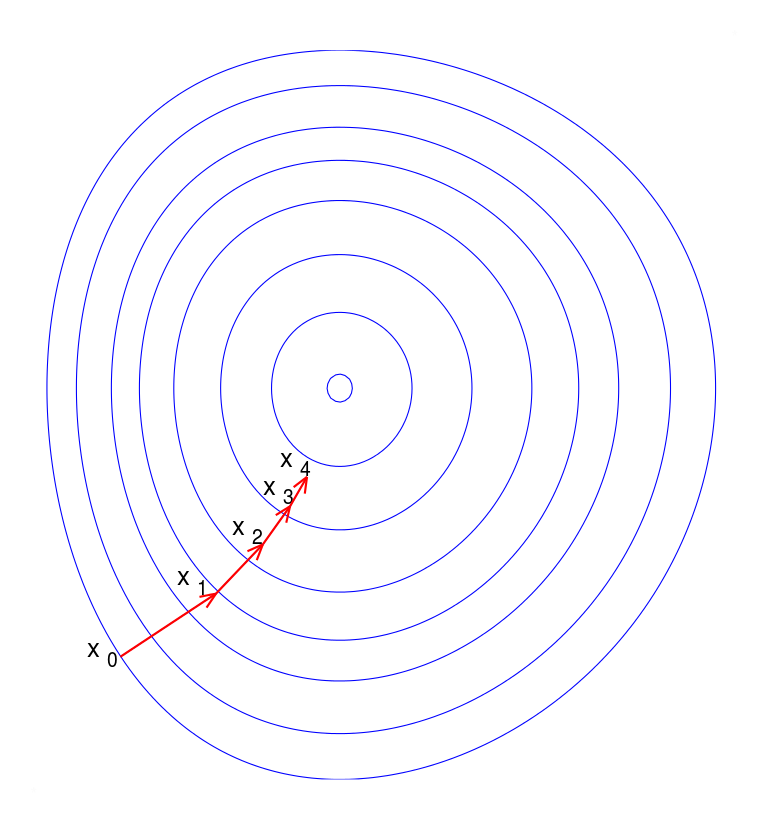



**(exercise)** Let's fill in the pseudocode for this training algorithm. To know that our implementation is correct, we'll evaluate and keep track of the value of the objective function at each step. If the objective function value decreases, we'll know we've probably implemented the algorithm correctly.

In [ ]:
# Training loop
n_dim = 2
n_iter = 10000
eta = 0.0001   # Learning rate / step size
w = 0.01 * np.random.randn(n_dim) # initial value
b = 0.0 # initial value

cost_log = []

for ni in tqdm(range(n_iter)):
    # compute the gradients on the training data using the current parameters
    dw, db = grad_objective_fn(X_train, y_train, w, b)

    # update the parameters using learning rate * the gradient
    w -= eta * dw
    b -= eta * db

    # compute the objective (to see how we're doing)  
    cost = np.mean(objective_fn(X_train, y_train, w, b))
    cost_log.append(cost)

100%|██████████| 10000/10000 [00:02<00:00, 3382.43it/s]


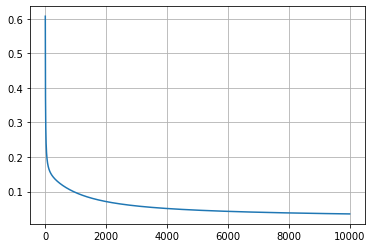

In [ ]:
# Plot cost over training iterations
plt.figure()
plt.plot(cost_log)
plt.grid(True)
plt.show()

## Evaluation 



Now that we've trained the model, let's see how good are model is by evaluating it on the test set. Note that we typically don't care about the actual value of the objective function $L$ we achieve; the objective function is a proxy for another objective we want but that is harder to optimize. In this case, we care about the **accuracy** of the model, or how often its predictions are accurate.

**(exercise)** Implement accuracy, and evaluate the accuracy and loss of the model on the test set.


In [ ]:
test_preds = predict(log_reg(X_test, w, b))

# accuracy code
def accuracy(targs, preds):
  return np.mean(np.equal(targs, preds))

print(accuracy(y_train, train_preds))
print(accuracy(y_test, test_preds))
print(np.mean(objective_fn(X_train, y_train, w, b)))
print(np.mean(objective_fn(X_test, y_test, w, b)))

0.990625
0.9925
0.03539544075114832
0.036832517847359705


## Scikit-learn

Scikit-learn provides implementations of many high-level models and convenience functions for optimizing them with lots of fancy knobs. As such, it is useful when you want to quickly test a model.

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(accuracy(y_test, preds))

0.995


# PyTorch


Manually computing and implementing gradients for every model we want to use is tedious, and can quickly become overwhelming as we move on to more compelx models.
Modern code frameworks for machine learning can automatically compute gradients, as well as provide other conveniences.

For the rest of the labs, we'll be using PyTorch, one such machine learning framework. We'll briefly go over the basics of PyTorch here.

The material in this section is borrowed from [here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

**What is PyTorch?**

PyTorch is a Python-based scientific computing package serving two broad purposes:
* A replacement for NumPy to use the power of GPUs and other accelerators.
* An automatic differentiation library that is useful to implement neural networks.

**Goal of this tutorial:**

Understand PyTorch’s Tensor library and neural networks at a high level.
Train a small neural network to classify images

## Tensors

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other specialized hardware to accelerate computing. If you’re familiar with ndarrays, you’ll be right at home with the Tensor API. If not, follow along in this quick API walkthrough.

In [ ]:
import torch

### Tensor Initialization

Tensors can be initialized in various ways. Take a look at the following examples:

**Directly from data**

Tensors can be created directly from data. The data type is automatically inferred.

In [ ]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

**From a NumPy array**

Tensors can be created from NumPy arrays (and vice versa).

In [ ]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

**From another tensor:**

The new tensor retains the properties (shape, datatype) of the argument tensor, unless explicitly overridden.

In [ ]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

**With random or constant values:**

shape is a tuple of tensor dimensions. In the functions below, it determines the dimensionality of the output tensor.

### Tensor Attributes

Tensor attributes describe their shape, datatype, and the device on which they are stored.

In [ ]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

### Tensor Operations

Over 100 tensor operations, including transposing, indexing, slicing, mathematical operations, linear algebra, random sampling, and more are comprehensively described here.

Each of them can be run on the GPU (at typically higher speeds than on a CPU). If you’re using Colab, allocate a GPU by going to Edit > Notebook Settings.

In [ ]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
  tensor = tensor.to('cuda')

Try out some of the operations from the list. If you’re familiar with the NumPy API, you’ll find the Tensor API a breeze to use.

**Standard numpy-like indexing and slicing:**

In [ ]:
tensor = torch.ones(4, 4)
tensor[:,1] = 0
print(tensor)

**Joining tensors** You can use torch.cat to concatenate a sequence of tensors along a given dimension. See also torch.stack, another tensor joining op that is subtly different from torch.cat.

In [ ]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

**Multiplying tensors**

In [ ]:
# This computes the element-wise product
print(f"tensor.mul(tensor) \n {tensor.mul(tensor)} \n")
# Alternative syntax:
print(f"tensor * tensor \n {tensor * tensor}")

This computes the matrix multiplication between two tensors



In [ ]:
print(f"tensor.matmul(tensor.T) \n {tensor.matmul(tensor.T)} \n")
# Alternative syntax:
print(f"tensor @ tensor.T \n {tensor @ tensor.T}")

**In-place operations** Operations that have a _ suffix are in-place. For example: x.copy_(y), x.t_(), will change x.

In [ ]:
print(tensor, "\n")
tensor.add_(5)
print(tensor)

### Bridge with NumPy

Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.

### Tensor to NumPy array

In [ ]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

A change in the tensor reflects in the NumPy array.

In [ ]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

NumPy array to Tensor



In [ ]:
n = np.ones(5)
t = torch.from_numpy(n)

Changes in the NumPy array reflects in the tensor.

In [ ]:
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

## Models in PyTorch

PyTorch provides a submodule for implementing and building machine learning models called `torch.nn` (`nn` for neural networks). `nn` implements many common mathematical transformations as functions that can be chained together to build machine learning modules. Let's go over an example of creating and using logistic regression in PyTorch. 

In [ ]:
import torch.nn as nn

class BinaryLogisticRegression(nn.Module):

  def __init__(self, input_dim):
    super(BinaryLogisticRegression, self).__init__()
    self.linear = nn.Linear(input_dim, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    outputs = self.sigmoid(self.linear(input)) # includes the bias term
    return outputs

model = BinaryLogisticRegression(n_dim) # instantiate model
print(f"Model: {model}")
print(f"Linear weights:\n {model.linear.weight}")
print(f"Linear bias:\n {model.linear.bias}")
print()
print(f"Dummy model outputs: {model(torch.rand(2))}")

Model: BinaryLogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Linear weights:
 Parameter containing:
tensor([[ 0.3328, -0.3408]], requires_grad=True)
Linear bias:
 Parameter containing:
tensor([0.2736], requires_grad=True)

Dummy model outputs: tensor([0.5884], grad_fn=<SigmoidBackward>)


**(instructor notes)**

* implement models as classes that inherit from `nn.Module`
* (may need to refresh Python classes)
* initialize modules (and implicitly parameters) in `model.__init__()` and save them as attributes of the model
* define the actual math of the model in `model.forward()`
* call the model as a function, which will under the hood call `model.forward()`
* can inspect the weights of each layer like above

## A Gentle Introduction To `torch.autograd`

`torch.autograd` is PyTorch’s automatic differentiation engine that powers neural network training. In this section, you will get a conceptual understanding of how autograd helps a neural network train.

### Background

Neural networks (NNs) are a collection of nested functions that are executed on some input data. These functions are defined by parameters (consisting of weights and biases), which in PyTorch are stored in tensors.

Training a NN happens in two steps:

**Forward Propagation:** In forward prop, the NN makes its best guess about the correct output. It runs the input data through each of its functions to make this guess.

**Backward Propagation:** In backprop, the NN adjusts its parameters proportionate to the error in its guess. It does this by traversing backwards from the output, collecting the derivatives of the error with respect to the parameters of the functions (gradients), and optimizing the parameters using gradient descent. For a more detailed walkthrough of backprop, [check out this video from 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

### Differentiation in Autograd

In [ ]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

We create another tensor Q from a and b.

$Q=3a^{3} - b^{2}$

In [ ]:
Q = 3*a**3 - b**2

Let’s assume a and b to be parameters of an NN, and Q to be the error. In NN training, we want gradients of the error w.r.t. parameters, i.e.

$\frac{\partial Q}{\partial a} = 9a^{2}$

$\frac{\partial Q}{\partial b} = -2b$

When we call .backward() on Q, autograd calculates these gradients and stores them in the respective tensors’ .grad attribute.

We need to explicitly pass a gradient argument in Q.backward() because it is a vector. gradient is a tensor of the same shape as Q, and it represents the gradient of Q w.r.t. itself, i.e.

$\frac{\partial Q}{\partial Q} = 1$

Equivalently, we can also aggregate Q into a scalar and call backward implicitly, like Q.sum().backward().



In [ ]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

Gradients are now deposited in a.grad and b.grad

In [ ]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)